<a href="https://colab.research.google.com/github/ryanleeallred/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 132
## Sampling, Confidence Intervals, and Hypothesis Testing

---

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

---

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one!

Here are some of the others to be aware of:

- $\chi^2$ (chi-squared) test
- Distribution tests (e.g. normal test)
- Kruskal-Wallis H-Test

---

### One-way chi square test

[Wikipedia Article](https://en.wikipedia.org/wiki/Chi-squared_test)

- Chi square can take any crosstab/table and test the independence of rows/cols
- The null hypothesis is that the rows/cols are independent -> low chi square
- The alternative is that there is a dependence -> high chi square
- Be aware! Chi square does *not* tell you direction/causation

In [2]:
# One-way chi squared test using Python

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(stats.chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(stats.chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


---

### Distribution Tests

We often assume that something is normal, but it can be important to *check*.

For example, later on with predictive modeling, a typical assumption is that residuals (prediction errors) are normal - checking is a good diagnostic

In [3]:
# The Poisson distribution models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(stats.normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=26.008239646286924, pvalue=2.2510364054837765e-06)


---

### Kruskal-Wallis H-Test

- Compare the median rank between 2+ groups
- Can be applied to ranking decisions/outcomes/recommendations
- The underlying math comes from chi-square distribution, and is best for n>5

In [4]:
x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(stats.kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(stats.kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

---

### Degrees of Freedom

[What Are Degrees of Freedom in Statistics?](https://blog.minitab.com/blog/statistics-and-quality-data-analysis/what-are-degrees-of-freedom-in-statistics)

- Technically defined as:

> The dimension of the domain of a vector.

- Less technically / more broadly defined as:

> The number of "observations" in the data that are free to vary when estimating statistical parameters.

- Or...

> The freedom to vary.

- 7 hats; one for each day of the week. As the week progresses, one's freedom of choice between the remaining hats decreases.
  - On the last day, one doesn't have a choice—no freedom to vary.

In [ ]:
mean = 20
n = 7
s = [5, 9, 10, 20, 15, 12, 69]

- The first 6 days add up to 71
- The mean has to be 20
- I need the sum of all the values in the list to be 140

$7 \cdot 20 = 140$

- The last value in the list ***has*** to be:

$140 - 71 = 69$

---

## T-test Assumptions

<https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php>

1. Independence of means
2. "Dependent Variable" (sample means) are Distributed Normally
3. "Homogeneity" of Variance? 

##### ---- Ø ----

#### 1. Independence of Means

*aka: Unrelated groups*

> Are the means of our voting data independent (do not affect the outcome of one another)?
  
The best way to increase thel likelihood of our means being independent is to randomly sample (which we did not do).

*Note about variance calculation:

> *By default, pandas uses the sample variance of $n-1$, 
> while numpy uses the population variance by default.

In [ ]:
# Take a look at the 2-sample t-test method documentation
?stats.ttest_ind

#### 2. "Homogeneity" of Variance? 

> Is the magnitude of the variance between the two roughly the same?

I think we're OK on this one for the voting data, although it probably could be better, one party was larger than the other.

If we suspect this to be a problem then we can use Welch's T-test. 

In [ ]:
?ttest_ind

#### 3. "Dependent Variable" (sample means) are Distributed Normally

<https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50>

Lots of statistical tests depend on normal distributions. We can test for normality using Scipy as was shown above.

This assumption is often assumed even if the assumption is a weak one. If you strongly suspect that things are not normally distributed, you can transform your data to get it looking more normal and then run your test.

> This problem is reduced with larger sample sizes (yay Central Limit Theorem) and is often why you don't hear it brought up.

People declare the assumption to be satisfied either way. 

---

## Central Limit Theorem



In [9]:
# Create a ton of simulated observations in a similar way to a Monte Carlo
sample_means = []
for _ in range(0,3000):
  coinflips = np.random.binomial(n=1, p=.5, size=12)
  one_sample = coinflips
  sample_means.append(coinflips.mean())

print(len(sample_means))
print(sample_means[:50])

3000
[0.8333333333333334, 0.4166666666666667, 0.5, 0.5, 0.5833333333333334, 0.75, 0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.6666666666666666, 0.5833333333333334, 0.6666666666666666, 0.5833333333333334, 0.5, 0.4166666666666667, 0.9166666666666666, 0.25, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5, 0.5, 0.6666666666666666, 0.4166666666666667, 0.3333333333333333, 0.5, 0.5833333333333334, 0.5, 0.5833333333333334, 0.5833333333333334, 0.3333333333333333, 0.5833333333333334, 0.75, 0.25, 0.5833333333333334, 0.4166666666666667, 0.4166666666666667, 0.3333333333333333, 0.4166666666666667, 0.5833333333333334, 0.5833333333333334, 0.9166666666666666, 0.5833333333333334, 0.25, 0.4166666666666667, 0.6666666666666666, 0.25]


In [10]:
df = pd.DataFrame({'single_sample': one_sample})
df.head()

,single_sample
0,0
1,0
2,0
3,0
4,1


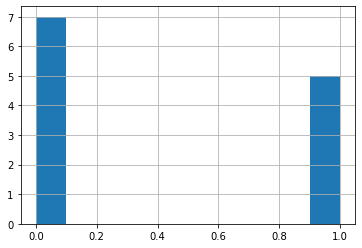

In [11]:
df.single_sample.hist();

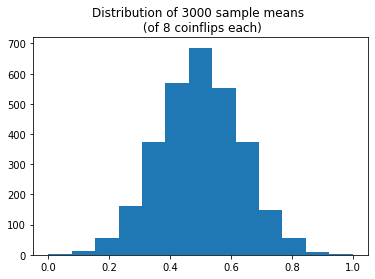

In [12]:
ax = plt.hist(sample_means, bins=13)
plt.title('Distribution of 3000 sample means \n (of 8 coinflips each)');

What does the Central Limit Theorem State?

> That no matter the initial distribution of the population, the distribution of sample means taken will approximate a normal distribution as $n \rightarrow \infty$.

This has very important implications for hypothesis testing and is precisely the reason why the t-distribution begins to approximate the normal distribution as our sample size increases. 

In [15]:
sample_means_small = []
sample_means_large = []

for _ in range(0,3000):
  coinflips_small = np.random.binomial(n=1, p=.5, size=20)
  coinflips_large = np.random.binomial(n=1, p=.5, size=100)
  one_small_sample = coinflips_small
  one_small_large = coinflips_large
  sample_means_small.append(coinflips_small.mean())
  sample_means_large.append(coinflips_large.mean())

print(len(sample_means_small))
print(sample_means_small[:100])

3000
[0.35, 0.45, 0.7, 0.8, 0.6, 0.45, 0.5, 0.5, 0.45, 0.5, 0.3, 0.3, 0.75, 0.3, 0.4, 0.4, 0.6, 0.3, 0.4, 0.35, 0.65, 0.55, 0.6, 0.6, 0.65, 0.75, 0.5, 0.6, 0.65, 0.75, 0.55, 0.5, 0.55, 0.5, 0.55, 0.5, 0.5, 0.4, 0.35, 0.5, 0.6, 0.55, 0.65, 0.6, 0.45, 0.65, 0.5, 0.65, 0.5, 0.55, 0.6, 0.45, 0.4, 0.35, 0.6, 0.3, 0.65, 0.4, 0.65, 0.6, 0.5, 0.4, 0.45, 0.65, 0.45, 0.35, 0.55, 0.5, 0.75, 0.45, 0.35, 0.4, 0.5, 0.6, 0.4, 0.55, 0.55, 0.5, 0.6, 0.7, 0.4, 0.55, 0.35, 0.45, 0.4, 0.45, 0.5, 0.6, 0.5, 0.45, 0.5, 0.6, 0.65, 0.35, 0.35, 0.55, 0.8, 0.45, 0.4, 0.6]


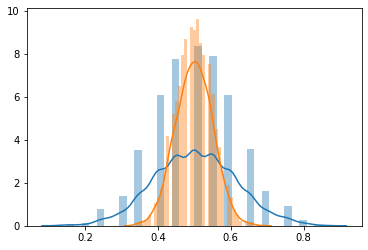

In [16]:
# Stack the distributions of the sample means on one plot
fig, ax = plt.subplots()
for sample in [sample_means_small, sample_means_large]:
  sns.distplot(sample)

- The yellow / orange distribution
  - more accurately represents the sample mean
  - less standard error
- The blue distribution
  - confidence interval is wider / not as confident

> Visualizes how the increase in $n$ tightens the confidence interval

---

## Standard Error of the Mean

What does it mean to "estimate"? the Population mean?

In [17]:
# Sample mean for a single sample
df.single_sample.mean()

0.4166666666666667

---

## Build and Interpret a Confidence Interval

<img src="https://github.com/ryanallredblog/ryanallredblog.github.io/blob/master/img/Confidence_Interval.png?raw=true" width=400>

## $\bar{X} ± t \frac{s}{\sqrt{n}}$

In [19]:
def confidence_interval(data, confidence=0.95):
    """
    Calculates a confidence interval around a sample mean for given data,
    using t-distribution and two-tailed test, default 95% confidence. 

    Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval

    Returns:
    tuple of (mean, lower bound, upper bound)
    """
    data = np.array(data)  # Standardize to numpy array
    mean = np.mean(data)
    n = len(data)
    
    # Stdev divided by sqare root of n (degrees of freedom / # observations)
    stderr = np.std(data, ddof=1) / np.sqrt(n)
    # stderr = stats.sem(data)
    
    # Std error multiplied by t-statistic
    margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    print(margin_of_error)

    return (mean, mean - margin_of_error, mean + margin_of_error)

In [29]:
# Create some more coinflips
coinflips_42 = np.random.binomial(n=1, p=0.5, size=42)
print(np.std(coinflips_42, ddof=1))  # ddof=1 tells numpy to use sample var/stdev
print(coinflips_42)

0.496795772414547
[1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0
 1 1 0 1 1]


In [30]:
# Calculate the (mean, lower_bound, upper_bound)
confidence_interval(coinflips_42)

0.15481246046014208


(0.5952380952380952, 0.44042563477795316, 0.7500505556982373)

In [31]:
# More coinflips
coinflips_500 = np.random.binomial(n=1, p=0.5, size=500)
print(np.std(coinflips_500, ddof=1))
print(coinflips_500[:50])

0.4998236161833385
[1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 0 0 1 1 1 0 1 1 0 1]


In [32]:
# Calculate the (mean, lower_bound, upper_bound)
confidence_interval(coinflips_500)

0.04391718672717477


(0.526, 0.48208281327282526, 0.5699171867271748)

#### Looking at stats.t.ppf

`stats.t.ppf(probability cutoff, degrees of freedom)`

95% confidence_level -> 0.25

(1 - confidence_level) == 0.05 / 2 -> 0.25

In [36]:
# Break up the one-liner in the function into its component atoms
n = 42
confidence_level = 0.95
dof = n - 1

stats.t.ppf((1 + confidence_level) / 2, dof)  # The plus gives the positive t-statistic

2.0195409639828936

---

## Graphically Represent a Confidence Interval

0.15481246046014208


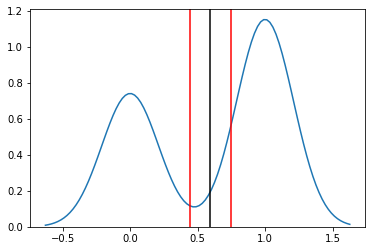

In [37]:
coinflips_69 = np.random.binomial(n=1, p=0.5, size=69)
sns.kdeplot(coinflips_69)
ci = confidence_interval(coinflips_42)
plt.axvline(x=ci[1], color="r")
plt.axvline(x=ci[2], color="r")
plt.axvline(x=ci[0], color="k")

---

## Relationship between Confidence Intervals and T-tests

Confidence Interval == Bounds of statistical significance for our t-test

A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis

A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis

In [43]:
# More coinflips
coinflip_means = []
for x in range(0,100):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  coinflip_means.append(coinflips.mean())

print(coinflip_means[:16])

[0.5333333333333333, 0.5333333333333333, 0.26666666666666666, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.4666666666666667, 0.5, 0.4, 0.6333333333333333, 0.4, 0.5333333333333333, 0.5, 0.6, 0.43333333333333335, 0.5333333333333333]


In [45]:
# Sample Size
n = len(coinflip_means)

# Degrees of Freedom
dof = n-1

# The Mean of Means
mean = np.mean(coinflip_means)

# Sample Standard Deviation
sample_std = np.std(coinflip_means, ddof=1)

# Standard Error
std_err = sample_std/n**.5

CI = stats.t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.4900467934148352, 0.5299532065851646)


In [46]:
'''You can roll your own CI calculation pretty easily. 
The only thing that's a little bit challenging 
is understanding the t stat lookup'''

# 95% confidence interval
t_stat = stats.t.ppf(.975, dof)
print("t Statistic:", t_stat)

CI = (mean - (t_stat * std_err), mean + (t_stat * std_err))
print("Confidence Interval", CI)

t Statistic: 1.9842169515086827
Confidence Interval (0.4900467934148352, 0.5299532065851646)


A null hypothesis that's just inside of our confidence interval == fail to reject



In [48]:
stats.ttest_1samp(coinflip_means, .4901)

Ttest_1sampResult(statistic=1.9789259017836531, pvalue=0.050602226268170326)

A null hypothesis that's just outside of our confidence interval == reject



In [50]:
stats.ttest_1samp(coinflip_means, .4899)

Ttest_1sampResult(statistic=1.9988146043141402, pvalue=0.04837004157161158)

---

## Run a $\chi^{2}$ Test "by hand" (Using Numpy)

\begin{align}
\chi^2 = \sum \frac{(observed_{ij}-expected_{ij})^2}{(expected_{ij})}
\end{align}

Chi-squared test is testing for relationships between two categorical variables.

Inner cells of the table is called a "contingency table".

In [51]:
# Load the "adults" dataset from github
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [52]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [53]:
df.describe(exclude="number")

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [54]:
cut_points = [0, 9, 19, 29, 39, 49, 1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [55]:
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [56]:
df['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [57]:
# Sort first to workaround a Pandas crosstab bug
df = df.sort_values(by='hours_per_week_categories', ascending=True)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
31290,55,Self-emp-not-inc,41938,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,8,United-States,<=50K,0-9
5172,32,NaN,134886,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,2,United-States,>50K,0-9
22928,17,NaN,332666,10th,6,Never-married,NaN,Own-child,White,Female,0,0,4,United-States,<=50K,0-9
7902,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K,0-9
6604,41,Private,406603,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,6,Iran,<=50K,0-9


In [58]:
# Create contingency table
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)

contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [59]:
# Female count / row
femalecount = contingency_table.iloc[0][0:6].values
femalecount

array([ 235,  671, 1287, 1914, 5636, 1028])

In [60]:
# Male couint / row
malecount = contingency_table.iloc[1][0:6].values
malecount

array([  223,   575,  1105,  1753, 12700,  5434])

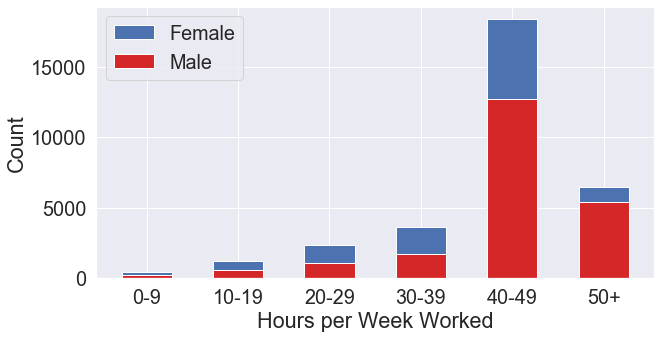

In [61]:
# Plot male / female with bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, malecount, 0.55, color='#d62728')
p2 = plt.bar(categories, femalecount, 0.55, bottom=malecount)
plt.legend((p2[0], p1[0]), ('Female', 'Male'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

### Expected Value Calculation

\begin{align}
expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}  
\end{align}

In [62]:
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values

print(row_sums)
print(col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [63]:
total = contingency_table.loc['All','All']
total

32561

In [64]:
df.shape[0]

32561

In [65]:
expected = []

for i in range(len(row_sums)):
    expected_row = []
    for column in col_sums:
        expected_val = column*row_sums[i]/total
        expected_row.append(expected_val)
    expected.append(expected_row)
  

expected = np.array(expected)
print(expected.shape)  
print(expected)

(2, 6)
[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [66]:
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values
print(observed.shape)
observed

(2, 6)


array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

### Chi-Squared Statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [67]:
# Array broadcasting will work with numpy arrays but not python lists
chi_squared = ((observed - expected)**2/(expected)).sum() 
print(f"Chi-Squared: {chi_squared}")  # Chi-Squared numbers are generally much larger

Chi-Squared: 2287.190943926107


#### Degrees of Freedom of a Chi-squared test

degrees_of_freedom = (num_rows - 1)(num_columns - 1)

In [70]:
# Calculate Degrees of Freedom
dof = (len(row_sums) - 1) * (len(col_sums) - 1)
print(f"Degrees of Freedom: {dof}")    

Degrees of Freedom: 5


> *Note:* Chi-Square will be on sprint challenge, but can use the NumPy one-liner method

---

## Run a $\chi^{2}$ Test using Scipy

In [69]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2287.190943926107
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


Null Hypothesis: Hours worked per week bins is **independent** of sex. 

Due to a p-value of 0, we REJECT the null hypothesis that hours worked per week and sex are independent, and conclude that there is an association between hours worked per week and sex.